In [1]:
sample_or_prod = True #True = sample, False = production

batch_size = 64 #ajust to suit memory capacity of hardware.

In [2]:
from theano.sandbox import cuda
cuda.use('gpu0')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [3]:
HOMEPATH = "/home/ubuntu/fastai/"

DATA_PATH = HOMEPATH+"data/Kaggle_dogs-vs-cats-redux-kernels-edition/"

MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print "WORKING_DATA:", WORKING_DATA
print "WORKING_TEST:", WORKING_TEST
print "WORKING_TRAIN:", WORKING_TRAIN
print "WORKING_VALID:", WORKING_VALID
print "s_or_p:", s_or_p


WORKING_DATA: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/
WORKING_TEST: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/
WORKING_TRAIN: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/
WORKING_VALID: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/
s_or_p: _sample_


In [4]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile


In [5]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('os.getcwd:', '/home/ubuntu/fastai')


Using Theano backend.


In [6]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition
.
├── models
│   ├── train_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_prod_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_data_prod_.bc
│   │   ├── data
│   │   └── meta
│   └── valid_data_sample_.bc
│       ├── data
│       └── meta
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── valid
│       ├── cat
│       └── dog
├── test
│   └── unknown
├── train
│   ├── cat
│   └── dog
└── valid
    ├── cat
    └── dog

43 directories


In [7]:
CATEGORIES = ['cat/', 'dog/']#nb: do not change order or trailing slash
UNKNOWN = 'unknown/'


In [8]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)


#delete the variables we don't need to prevent accidental use.
del SAMPLE_DATA_PATH
del SAMPLE_TEST_PATH
del SAMPLE_TRAIN_PATH
del SAMPLE_VALID_PATH
del TEST_PATH
del TRAIN_PATH
del VALID_PATH


In [9]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]

In [10]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print (dir_, len(dirFileList(dir_)))


In [11]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, "\n")
        count +=1

In [12]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [13]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [14]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/ 16
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/ 1
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/unknown/ 2500
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/cat/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/dog/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/cat/ 750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/dog/ 75

In [15]:
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=batch_size)
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=batch_size)

Found 3500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [16]:
print ("trn_batches:", type(trn_batches))
print ("val_batches:", type(val_batches))

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'>
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'>


In [17]:
print ("WORKING_DATA:", WORKING_DATA)
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(WORKING_DATA)
#utils.get_classes
#return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
#        val_batches.filenames, batches.filenames, test_batches.filenames)
#NB: get_classes expects data in subdirectories 'train', 'valid', 'test'
print ("val_classes:", type(val_classes), val_classes.shape, val_classes[0:5])
print ("trn_classes:", type(trn_classes), trn_classes.shape, trn_classes[0:5])
print ("val_labels:", type(val_labels), val_labels.shape, "\n", val_labels[0:5])
print ("trn_labels:", type(trn_labels), trn_labels.shape, "\n",trn_labels[0:5])
print ("val_filenames:", type(val_filenames), len(val_filenames))
print ("filenames:", type(filenames), len(filenames))
print ("test_filenames:", type(test_filenames), len(test_filenames))

#NBB: val_labels = onehot(val_classes) & trn_labels = onehot(trn_classes). onehot 'converts' from 1 to [0,1]

WORKING_DATA: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/
Found 3500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 2500 images belonging to 1 classes.
val_classes: <type 'numpy.ndarray'> (1500,) [0 0 0 0 0]
trn_classes: <type 'numpy.ndarray'> (3500,) [0 0 0 0 0]
val_labels: <type 'numpy.ndarray'> (1500, 2) 
 [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
trn_labels: <type 'numpy.ndarray'> (3500, 2) 
 [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
val_filenames: <type 'list'> 1500
filenames: <type 'list'> 3500
test_filenames: <type 'list'> 2500


In [32]:
model = Vgg16().model
#model is stock vgg16 model, all layers trainable, input [3,224,224], output 1,000 classes. 
#needs to be modified to predict 2 classes.
#model.summary()

In [33]:
#showLayersInfo(model)

In [34]:
conv_layers,fc_layers = split_at(model, Convolution2D)
#utils.split_at(model, layer_type) 
#splits model at last occurrance of layer_type. (in this case Convolution2D)


In [35]:
print ("model        # of layers:",  len(model.layers))
print ("conv_layers  # of layers:",  len(conv_layers))
print ("fc_layers    # of layers:", len(fc_layers))

model        # of layers: 38
conv_layers  # of layers: 31
fc_layers    # of layers: 7


In [36]:
conv_model = Sequential(conv_layers)
#31 layers, all trainable, last layer = Convolution2D
#showLayersInfo(conv_model)

In [37]:
#showLayersInfo(Sequential(fc_layers))
#7 layers, all trainable, last layer = Dence, 1000 classes output.

In [38]:
startTime= datetime.now()
print ("startTime:", startTime)

val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
print ("val_features:", val_features.shape)
trn_features = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("trn_features:", trn_features.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#https://keras.io/models/sequential/
#predict_generator(self, generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#Returns: A Numpy array of predictions.
#sample mode: takes approx 2 minutes to run/

startTime: 2017-12-20 10:30:36.991712
val_features: (1500, 512, 14, 14)
trn_features: (3500, 512, 14, 14)
Time elapsed (hh:mm:ss.ms) 0:02:11.220578


In [39]:
#save_array(MODEL_PATH + 'train_convlayer_features.bc', trn_features)
#save_array(MODEL_PATH + 'valid_convlayer_features.bc', val_features)

In [40]:
#trn_features = load_array(MODEL_PATH+'train_convlayer_features.bc')
#val_features = load_array(MODEL_PATH+'valid_convlayer_features.bc')

In [41]:
startTime= datetime.now()
print ("startTime:", startTime)

trn = get_data(WORKING_TRAIN)
print ("trn:", trn.shape)
val = get_data(WORKING_VALID)
print ("val:", val.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))
#sample mode: tales approx 50s to run

startTime: 2017-12-20 10:32:48.234473
Found 3500 images belonging to 2 classes.
trn: (3500, 3, 224, 224)
Found 1500 images belonging to 2 classes.
val: (1500, 3, 224, 224)
Time elapsed (hh:mm:ss.ms) 0:00:50.524259


In [42]:
#save_array(MODEL_PATH+'train_data.bc', trn)
#save_array(MODEL_PATH+'valid_data.bc', val)

In [43]:
#trn = load_array(MODEL_PATH+'train_data.bc')
#val = load_array(MODEL_PATH+'valid_data.bc')

In [44]:
#showLayersInfo(model)

In [45]:
print ("@start# of layers:", len(model.layers))#should be 38 layers before popping
model.pop()
model.pop()
print ("@end# of layers:", len(model.layers))#should be 36 layers after popping
#showLayersInfo(model)

@start# of layers: 38
@end# of layers: 36
Number of layers :  36
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Co

In [47]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
                                                                   zeropadding2d_14[1][0]           
___________________________________________________________________________________________

convolution2d_25 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_25[0][0]           
                                                                   zeropadding2d_25[1][0]           
____________________________________________________________________________________________________
zeropadding2d_26 (ZeroPadding2D) (None, 512, 16, 16)   0           convolution2d_25[0][0]           
                                                                   convolution2d_25[1][0]           
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 512, 14, 14)   2359808     zeropadding2d_26[0][0]           
                                                                   zeropadding2d_26[1][0]           
____________________________________________________________________________________________________
maxpooling2d_10 (MaxPooling2D)   (None, 512, 7, 7)     0           convolution2d_26[0][0]  

In [ ]:
showLayersInfo(model)

In [48]:
print ("trn_batches:", type(trn_batches), "trn_batches.nb_sample:", trn_batches.nb_sample)
print ("val_batches:", type(val_batches), "val_batches.nb_sample:", val_batches.nb_sample)

trn_batches: <class 'keras.preprocessing.image.DirectoryIterator'> trn_batches.nb_sample: 3500
val_batches: <class 'keras.preprocessing.image.DirectoryIterator'> val_batches.nb_sample: 1500


In [50]:
startTime= datetime.now()
print ("startTime:", startTime)

ll_val_feat = model.predict_generator(val_batches, val_batches.nb_sample)
print ("ll_val_feat:", ll_val_feat.shape)
ll_feat = model.predict_generator(trn_batches, trn_batches.nb_sample)
print ("ll_feat:", ll_feat.shape)

timeElapsed=datetime.now()-startTime
print ('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#NB: 64^2 = 4096
#sample mode: takes approx 2'11"

startTime: 2017-12-20 10:38:31.871348
ll_val_feat: (1500, 4096)
ll_feat: (3500, 4096)
Time elapsed (hh:mm:ss.ms) 0:02:11.662453


In [53]:
save_array(MODEL_PATH + 'train_ll_feat.bc', ll_feat)
save_array(MODEL_PATH + 'valid_ll_feat.bc', ll_val_feat)

In [54]:
#ll_feat = load_array(MODEL_PATH+ 'train_ll_feat.bc')
#ll_val_feat = load_array(MODEL_PATH + 'valid_ll_feat.bc')

In [55]:
startTime= datetime.now()
print ("startTime:", startTime)

test = get_data(WORKING_TEST)
print (type(test), test.shape)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

#sample mode: takes approx 

Found 2500 images belonging to 1 classes.
<type 'numpy.ndarray'> (2500, 3, 224, 224)


In [56]:
save_array(MODEL_PATH+'test_data.bc', test)

In [57]:
#test = load_array(MODEL_PATH+'test_data.bc')

In [58]:
def get_ll_layers():
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    return [ 
        BatchNormalization(input_shape=(4096,)),
        Dropout(0.5),
        Dense(2, activation='softmax') 
        ]

In [71]:
def train_last_layer(i):
    #nb: i is used in the filename to save weights.
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #set learning rate, train model, set learning rate again, train model.
    #pop last three layers from vgg16 model, make all layers non trainable.
    #add 3 layers created in get_ll_layers to end of model.
    #copy weights from 3 layers just trained to last three layers in vgg16 model.
    ll_layers = get_ll_layers()
    ll_model = Sequential(ll_layers)
    ll_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    ll_model.optimizer.lr=1e-5
    history = ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=12)
    print ("train_last_layer:i:", i, ", ll_model.optimizer.lr:", ll_model.optimizer.lr )
    plot_history(history)
    
    ll_model.optimizer.lr=1e-7
    ll_model.fit(ll_feat, trn_labels, validation_data=(ll_val_feat, val_labels), nb_epoch=1)
    #nb: cannot show history with only one epoch.
    print ("ll_model.optimizer.lr:", ll_model.optimizer.lr)
    ll_model.save_weights(MODEL_PATH+'ll_bn' + i + '.h5')

    #create new vgg16 model & pop last 3 layers.
    vgg = Vgg16()
    model = vgg.model
    print("train_last_layer, model just created from Vgg16(), # layers = ", len(model.layers))
    model.pop(); model.pop(); model.pop()
    #
    for layer in model.layers: layer.trainable=False
    #set all layers to non trainable
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    #create three layers ()
    ll_layers = get_ll_layers()
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense, add these layers to model.
    for layer in ll_layers: model.add(layer)
    #copy the weights from the above trained ll_model to the just added  last 3 layers in model.
    for l1,l2 in zip(ll_model.layers, model.layers[-3:]):
        l2.set_weights(l1.get_weights())
    
    #compile model so it is ready for use.
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save_weights(MODEL_PATH+'bn' + i + '.h5')
    print ("@ end of train_last_layer, # layers = ", len(model.layers))
    showLayersInfo(model)
    return model

In [61]:
def get_conv_model(model):
    #split model into 2 sets of layers. 
    #conv_layers = start up to & including the last Convolution2D
    #fc_layers   = rest of the model
    #returns model, list of layers, int position of last Convolution2D layer. 
    
    layers = model.layers
    
    #last_conv_idx = index of last Convolution2D layer
    last_conv_idx = [index for index,layer in enumerate(layers) 
                         if type(layer) is Convolution2D][-1]

    conv_layers = layers[:last_conv_idx+1]
    conv_model = Sequential(conv_layers)
    fc_layers = layers[last_conv_idx+1:]
    return conv_model, fc_layers, last_conv_idx

In [62]:
def get_fc_layers(p, in_shape):
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
        ]

In [73]:
def train_dense_layers(i, model):
    #nb: i is used in the filename to save weights.
    
    print ("start: train_dense_layers: i:", i)
    print ("len(model.layers):", len(model.layers))
    #split model about last Convolutional2D layer
    conv_model, fc_layers, last_conv_idx = get_conv_model(model)
    #conv_model = Sqeuential(conv_layers) = list of layers, from start up to & including the last Convolution2D layer.
    #fc_layers   = rest of the model
    
    
    #shape of last Convolution2D layer output.
    conv_shape = conv_model.output_shape[1:]
    
    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    fc_model = Sequential(get_fc_layers(0.5, conv_shape))
    #get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Dense, BatchNormalization, Dropout, Dense

    
    showLayersInfo(fc_model)
    showLayersInfo(Sequential(fc_layers))
    print ("len(fc_model.layers):", len(fc_model.layers))
    print ("len(fc_layers):", len(fc_layers))
    #copy weights from layers in fc_layers to the newly created fc_model. 
    for l1,l2 in zip(fc_model.layers, fc_layers): 
        print("l1:", l1)
        print("l2:", l2)
        weights = l2.get_weights()
        print ("l2.get_weights():", len(l2.get_weights()))
        print ("l1.get_weights():", len(l1.get_weights()))
        l1.set_weights(weights)
    
    
    fc_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
         batch_size=batch_size, validation_data=(val_features, val_labels))

    #setup data augmentation.
    gen = image.ImageDataGenerator(rotation_range=10, 
                                   width_shift_range=0.05, 
                                   width_zoom_range=0.05, 
                                   zoom_range=0.05, 
                                   channel_shift_range=10, 
                                   height_shift_range=0.05, 
                                   shear_range=0.05, 
                                   horizontal_flip=True)

    batches = gen.flow(trn, trn_labels, batch_size=batch_size)
    
    val_batches = image.ImageDataGenerator().flow(val, 
                                                  val_labels, 
                                                  shuffle=False, 
                                                  batch_size=batch_size)
    
    print ("type(val_batches):", type(val_batches), "val_batches.N:", val_batches.N)

    print ("len(conv_model.layers):", len(conv_model.layers))
    
    #set all layers in conv_model to non trainable
    for layer in conv_model.layers: 
        layer.trainable = False

    ##get_fc_layers creates 9 layers, with nominated input shape, nominated dropout rate
    #conv_shape ensures input shape from conv_model can be accepted.
    #add all layers to end of conv_model
    for layer in get_fc_layers(0.5, conv_shape): 
        conv_model.add(layer)
    print ("showLayersInfo(conv_model): after 1. setting layers to non trainable & 2. adding get_fc_layers to conv_model")
    showLayersInfo(conv_model)
        
    
    #copy weights from fc_model.layers to the last 9 layers in conv_model.
    #nb: weights in fc_model were trained 
    for l1,l2 in zip(conv_model.layers[last_conv_idx+1:], fc_model.layers): 
        l1.set_weights(l2.get_weights())

    conv_model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    conv_model.save_weights(model_path+'no_dropout_bn' + i + '.h5')
    
    
    conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.N, 
                             nb_epoch=1, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.N)
    
    #now make more of the models trainable.
    for layer in conv_model.layers[16:]: layer.trainable = True

    print ("showLayersInfo(conv_model): after 1. copying weights to conv_model from fc_model.layers.")
    print ("2. fitting, setting layers 16: to trainable.")
    
    showLayersInfo(conv_model)


    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.N, 
                             nb_epoch=8, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.N)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.optimizer.lr = 1e-7
    history = conv_model.fit_generator(batches, 
                             samples_per_epoch=batches.N, 
                             nb_epoch=10, 
                             validation_data=val_batches, 
                             nb_val_samples=val_batches.N)

    print ("history = conv_model.fit_generator(blah....), conv_model.optimizer.lr:", conv_model.optimizer.lr)
    plot_history(history)
    
    conv_model.save_weights(model_path + 'aug' + i + '.h5')

i: 0
Train on 3500 samples, validate on 1500 samples
Epoch 1/12
3500/3500 [==============================] - 0s - loss: 1.2625 - acc: 0.5366 - val_loss: 1.3201 - val_acc: 0.4267
Epoch 2/12
3500/3500 [==============================] - 0s - loss: 1.1726 - acc: 0.5526 - val_loss: 1.3464 - val_acc: 0.4087
Epoch 3/12
3500/3500 [==============================] - 0s - loss: 1.0954 - acc: 0.5774 - val_loss: 1.3974 - val_acc: 0.3953
Epoch 4/12
3500/3500 [==============================] - 0s - loss: 1.1023 - acc: 0.5791 - val_loss: 1.4412 - val_acc: 0.3867
Epoch 5/12
3500/3500 [==============================] - 0s - loss: 1.0688 - acc: 0.5880 - val_loss: 1.4669 - val_acc: 0.3767
Epoch 6/12
3500/3500 [==============================] - 0s - loss: 1.0710 - acc: 0.5897 - val_loss: 1.4793 - val_acc: 0.3733
Epoch 7/12
3500/3500 [==============================] - 0s - loss: 1.0637 - acc: 0.6011 - val_loss: 1.4743 - val_acc: 0.3707
Epoch 8/12
3500/3500 [==============================] - 0s - loss: 1.022

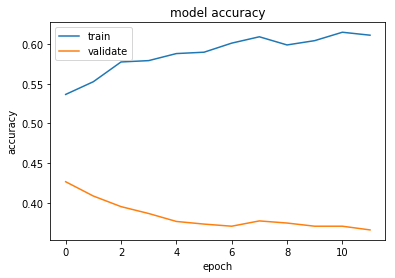

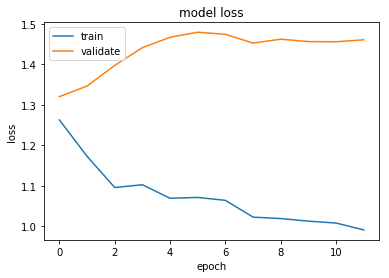

Train on 3500 samples, validate on 1500 samples
Epoch 1/1
3500/3500 [==============================] - 0s - loss: 0.9851 - acc: 0.6091 - val_loss: 1.4650 - val_acc: 0.3640
ll_model.optimizer.lr: 1e-07
train_last_layer, model just created from Vgg16(), # layers =  38
@ end of train_last_layer, # layers =  38
Number of layers :  38
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.p

ValueError: You called `set_weights(weights)` on layer "batchnormalization_15" with a  weight list of length 0, but the layer was expecting 4 weights. Provided weights: []...

In [72]:
#build the ensemble
#multiple model builds, model trainings. takes long time.
for i in range(5):
    i = str(i)
    print ("i:", i)
    model = train_last_layer(i)
    #a tthis point, model = vgg16 model, minus last three layers, plus layers BatchNormalization + Dropout + Dense
    #get_ll_layers:create 3 layers, BatchNormalization + Dropout + Dense
    #train_last_layer uses get_ll_layers to create 3 layer model, trains it, then pops last 3 layers from vgg16model
    #at end of train_last_layer model has 38 layers with last three layers being BatchNormalization + Dropout + Dense

    train_dense_layers(i, model)

In [ ]:
#Combine ensemble and test
ens_model = vgg_ft(2)
for layer in ens_model.layers: layer.trainable=True

In [46]:
def get_ens_pred(arr, fname):
    ens_pred = []
    for i in range(5):
        i = str(i)
        ens_model.load_weights('{}{}{}.h5'.format(model_path, fname, i))
        preds = ens_model.predict(arr, batch_size=batch_size)
        ens_pred.append(preds)
    return ens_pred